# 🧑‍⚖️ Legal Generator Evaluation

## Overview
This notebook evaluates different AI generators for legal question answering in the MyPocketLawyer system. We compare:

1. **Gemini 2.5 Flash** (Current system)
2. **GPT-4** (OpenAI)
3. **Llama 3.3 70B** (Groq)

## Evaluation Metrics
- **Accuracy**: How well the answer matches expected legal information
- **Completeness**: Coverage of all relevant legal aspects
- **Clarity**: Readability and citizen-friendly language
- **Citation Quality**: Proper referencing of legal sources
- **Response Time**: Speed of generation
- **Cost Efficiency**: API cost per query

In [8]:
import os
import sys
import json
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from dotenv import load_dotenv
from typing import Dict, List, Tuple
import numpy as np
from google import genai
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
# from langchain.prompts import PromptTemplate
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 🔧 Configuration & Setup

In [9]:
# Project paths
PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

# API Configuration
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

# Initialize clients
gemini_client = genai.Client(api_key=GEMINI_API_KEY) if GEMINI_API_KEY else None
openai_llm = ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4", temperature=0.2) if OPENAI_API_KEY else None
groq_llm = ChatGroq(api_key=GROQ_API_KEY, model="llama-3.3-70b-versatile", temperature=0.2) if GROQ_API_KEY else None

# API endpoints
BACKEND_URL = "http://localhost:8000"

print(f"🔑 Gemini API: {'✅' if GEMINI_API_KEY else '❌'}")
print(f"🔑 OpenAI API: {'✅' if OPENAI_API_KEY else '❌'}")
print(f"🔑 Groq API: {'✅' if GROQ_API_KEY else '❌'}")

🔑 Gemini API: ✅
🔑 OpenAI API: ✅
🔑 Groq API: ✅


## 📋 Test Dataset Creation

In [10]:
# Legal test questions with expected answer characteristics
test_questions = [
    {
        "id": 1,
        "question": "What are the fundamental rights guaranteed by the Constitution of Nepal?",
        "category": "Constitutional Law",
        "complexity": "medium",
        "expected_sources": ["Constitution of Nepal 2072"],
        "key_concepts": ["fundamental rights", "constitutional guarantees", "citizen rights"]
    },
    {
        "id": 2,
        "question": "What is the punishment for theft according to Nepali criminal law?",
        "category": "Criminal Law",
        "complexity": "easy",
        "expected_sources": ["The National Penal (Code) Act 2074"],
        "key_concepts": ["theft", "punishment", "criminal penalties"]
    },
    {
        "id": 3,
        "question": "What are the rights of workers regarding overtime pay in Nepal?",
        "category": "Labour Law",
        "complexity": "medium",
        "expected_sources": ["The Labour Act 2074"],
        "key_concepts": ["workers rights", "overtime", "compensation"]
    },
    {
        "id": 4,
        "question": "How can someone acquire citizenship of Nepal by descent?",
        "category": "Constitutional Law",
        "complexity": "hard",
        "expected_sources": ["Constitution of Nepal 2072"],
        "key_concepts": ["citizenship", "descent", "acquisition"]
    },
    {
        "id": 5,
        "question": "What is the procedure for marriage registration in Nepal?",
        "category": "Civil Law",
        "complexity": "medium",
        "expected_sources": ["The National Civil (Code) Act 2074"],
        "key_concepts": ["marriage", "registration", "civil procedure"]
    },
    {
        "id": 6,
        "question": "What are the grounds for termination of employment in Nepal?",
        "category": "Labour Law",
        "complexity": "hard",
        "expected_sources": ["The Labour Act 2074"],
        "key_concepts": ["employment termination", "labour rights", "dismissal"]
    },
    {
        "id": 7,
        "question": "What is considered domestic violence under Nepali law?",
        "category": "Criminal Law",
        "complexity": "medium",
        "expected_sources": ["The Criminal Offences Act 2074"],
        "key_concepts": ["domestic violence", "criminal offense", "protection"]
    },
    {
        "id": 8,
        "question": "What are the property rights of women in Nepal?",
        "category": "Civil Law",
        "complexity": "hard",
        "expected_sources": ["The National Civil (Code) Act 2074", "Constitution of Nepal 2072"],
        "key_concepts": ["women rights", "property", "inheritance"]
    }
]

print(f"📝 Created test dataset with {len(test_questions)} questions")
print(f"📊 Categories: {set(q['category'] for q in test_questions)}")
print(f"🎯 Complexity levels: {set(q['complexity'] for q in test_questions)}")

📝 Created test dataset with 8 questions
📊 Categories: {'Labour Law', 'Criminal Law', 'Constitutional Law', 'Civil Law'}
🎯 Complexity levels: {'medium', 'hard', 'easy'}


## 🤖 Generator Classes

In [11]:
class LegalGenerator:
    """Base class for legal text generators"""
    
    def __init__(self, name: str):
        self.name = name
        
    def generate(self, query: str, context: str) -> Dict:
        """Generate legal answer with timing and cost tracking"""
        raise NotImplementedError
        
    def create_prompt(self, query: str, context: str) -> str:
        """Create standardized prompt for fair comparison"""
        return f"""
You are MyPocketLawyer — an AI legal assistant for Nepali law.
Answer the user's question using the provided legal context.
Provide practical steps a normal citizen can take in compliance with the law,
without giving legal advice that replaces a licensed lawyer.

Question: {query}

Legal Context:
{context}

Return a clear, structured answer as if explaining to a normal citizen.
Include:
1. What the law says (with clause citations)
2. Practical steps the person can take safely and legally
3. Any important limitations or considerations

Answer:
"""


class GeminiGenerator(LegalGenerator):
    """Gemini 2.5 Flash generator (current system)"""
    
    def __init__(self):
        super().__init__("Gemini 2.5 Flash")
        self.client = gemini_client
        self.cost_per_1k_tokens = 0.075  # Estimated cost
        
    def generate(self, query: str, context: str) -> Dict:
        if not self.client:
            return {"error": "Gemini API not available"}
            
        start_time = time.time()
        
        try:
            prompt = self.create_prompt(query, context)
            response = self.client.models.generate_content(
                model="gemini-2.5-flash",
                contents=prompt
            )
            
            end_time = time.time()
            
            return {
                "answer": response.text,
                "response_time": end_time - start_time,
                "estimated_cost": len(prompt + response.text) / 1000 * self.cost_per_1k_tokens,
                "token_count": len(prompt + response.text),
                "error": None
            }
            
        except Exception as e:
            return {"error": str(e), "response_time": time.time() - start_time}


class OpenAIGenerator(LegalGenerator):
    """GPT-4 generator"""
    
    def __init__(self):
        super().__init__("GPT-4")
        self.llm = openai_llm
        self.cost_per_1k_tokens = 0.03  # Estimated cost
        
    def generate(self, query: str, context: str) -> Dict:
        if not self.llm:
            return {"error": "OpenAI API not available"}
            
        start_time = time.time()
        
        try:
            prompt = self.create_prompt(query, context)
            response = self.llm.invoke(prompt)
            
            end_time = time.time()
            
            return {
                "answer": response.content,
                "response_time": end_time - start_time,
                "estimated_cost": len(prompt + response.content) / 1000 * self.cost_per_1k_tokens,
                "token_count": len(prompt + response.content),
                "error": None
            }
            
        except Exception as e:
            return {"error": str(e), "response_time": time.time() - start_time}


class GroqGenerator(LegalGenerator):
    """Llama 3.3 70B generator via Groq"""
    
    def __init__(self):
        super().__init__("Llama 3.3 70B (Groq)")
        self.llm = groq_llm
        self.cost_per_1k_tokens = 0.59  # Estimated cost
        
    def generate(self, query: str, context: str) -> Dict:
        if not self.llm:
            return {"error": "Groq API not available"}
            
        start_time = time.time()
        
        try:
            prompt = self.create_prompt(query, context)
            response = self.llm.invoke(prompt)
            
            end_time = time.time()
            
            return {
                "answer": response.content,
                "response_time": end_time - start_time,
                "estimated_cost": len(prompt + response.content) / 1000 * self.cost_per_1k_tokens,
                "token_count": len(prompt + response.content),
                "error": None
            }
            
        except Exception as e:
            return {"error": str(e), "response_time": time.time() - start_time}


# Initialize generators
generators = [
    GeminiGenerator(),
    OpenAIGenerator(),
    GroqGenerator()
]

print(f"🤖 Initialized {len(generators)} generators:")
for gen in generators:
    print(f"   - {gen.name}")

🤖 Initialized 3 generators:
   - Gemini 2.5 Flash
   - GPT-4
   - Llama 3.3 70B (Groq)


## 🔍 Retrieval Helper Functions

In [14]:
def get_legal_context(query: str, k: int = 3) -> str:
    """Get legal context from the MyPocketLawyer backend"""
    try:
        response = requests.post(
            f"{BACKEND_URL}/query",
            json={"query": query, "k": k},
            timeout=30  # Increased timeout to 30 seconds
        )
        
        if response.status_code == 200:
            data = response.json()
            sources = data.get("sources", [])
            
            # Format context from sources
            context_parts = []
            for src in sources:
                context_parts.append(
                    f"Document: {src.get('document_title', 'Unknown')}\n"
                    f"Part {src.get('part_number', '')}: {src.get('part_title', '')}\n"
                    f"Article {src.get('article_number', '')}: {src.get('article_title', '')}\n"
                    f"Clause {src.get('clause_index', '')}\n"
                    f"Text: {src.get('text', '')}"
                )
            
            return "\n\n".join(context_parts)
        else:
            return f"Error retrieving context: {response.status_code}"
            
    except Exception as e:
        return f"Error retrieving context: {str(e)}"


def test_retrieval():
    """Test if retrieval system is working"""
    test_query = "What are citizenship rights?"
    context = get_legal_context(test_query)
    
    if "Error" in context:
        print(f"❌ Retrieval test failed: {context}")
        return False
    else:
        print(f"✅ Retrieval test passed. Context length: {len(context)} chars")
        return True

# Test retrieval system
retrieval_working = test_retrieval()

✅ Retrieval test passed. Context length: 1151 chars


## 🧪 Evaluation Metrics

In [15]:
def evaluate_answer_quality(answer: str, question_data: Dict) -> Dict:
    """Evaluate answer quality based on multiple criteria"""
    
    if not answer or "error" in answer.lower():
        return {
            "completeness": 0,
            "clarity": 0,
            "citation_quality": 0,
            "concept_coverage": 0,
            "overall_score": 0
        }
    
    # Completeness: Check for structured sections
    completeness_indicators = [
        "law says" in answer.lower() or "according to" in answer.lower(),
        "steps" in answer.lower() or "procedure" in answer.lower(),
        "consider" in answer.lower() or "limitation" in answer.lower()
    ]
    completeness = sum(completeness_indicators) / len(completeness_indicators)
    
    # Clarity: Length and readability indicators
    word_count = len(answer.split())
    clarity = min(1.0, max(0.1, (word_count - 50) / 200))  # Optimal 50-250 words
    
    # Citation quality: Look for legal references
    citation_indicators = [
        "article" in answer.lower(),
        "section" in answer.lower() or "clause" in answer.lower(),
        "act" in answer.lower() or "constitution" in answer.lower(),
        any(src in answer.lower() for src in question_data.get("expected_sources", []))
    ]
    citation_quality = sum(citation_indicators) / len(citation_indicators)
    
    # Concept coverage: Check for key concepts
    key_concepts = question_data.get("key_concepts", [])
    if key_concepts:
        concept_coverage = sum(
            1 for concept in key_concepts 
            if concept.lower() in answer.lower()
        ) / len(key_concepts)
    else:
        concept_coverage = 0.5  # Default if no concepts defined
    
    # Overall score (weighted average)
    overall_score = (
        completeness * 0.3 +
        clarity * 0.2 +
        citation_quality * 0.3 +
        concept_coverage * 0.2
    )
    
    return {
        "completeness": completeness,
        "clarity": clarity,
        "citation_quality": citation_quality,
        "concept_coverage": concept_coverage,
        "overall_score": overall_score
    }


def calculate_efficiency_score(response_time: float, cost: float) -> float:
    """Calculate efficiency score based on speed and cost"""
    # Normalize scores (lower is better for both time and cost)
    time_score = max(0, 1 - (response_time / 10))  # 10 seconds = 0 score
    cost_score = max(0, 1 - (cost / 0.1))  # $0.10 = 0 score
    
    return (time_score + cost_score) / 2


print("📊 Evaluation metrics configured")

📊 Evaluation metrics configured


## 🚀 Run Generator Evaluation

In [16]:
def run_generator_evaluation():
    """Run comprehensive generator evaluation"""
    
    if not retrieval_working:
        print("❌ Cannot run evaluation - retrieval system not working")
        return None
    
    results = []
    
    print("🚀 Starting generator evaluation...\n")
    
    for i, question_data in enumerate(test_questions, 1):
        question = question_data["question"]
        print(f"📝 Question {i}/{len(test_questions)}: {question[:60]}...")
        
        # Get legal context for this question
        context = get_legal_context(question)
        
        if "Error" in context:
            print(f"   ⚠️ Skipping due to context retrieval error")
            continue
        
        # Test each generator
        for generator in generators:
            print(f"   🤖 Testing {generator.name}...")
            
            # Generate answer
            result = generator.generate(question, context)
            
            if result.get("error"):
                print(f"      ❌ Error: {result['error']}")
                continue
            
            # Evaluate answer quality
            quality_metrics = evaluate_answer_quality(result["answer"], question_data)
            
            # Calculate efficiency
            efficiency_score = calculate_efficiency_score(
                result["response_time"], 
                result["estimated_cost"]
            )
            
            # Store results
            result_entry = {
                "question_id": question_data["id"],
                "question": question,
                "category": question_data["category"],
                "complexity": question_data["complexity"],
                "generator": generator.name,
                "answer": result["answer"],
                "response_time": result["response_time"],
                "estimated_cost": result["estimated_cost"],
                "token_count": result["token_count"],
                "efficiency_score": efficiency_score,
                **quality_metrics
            }
            
            results.append(result_entry)
            
            print(f"      ✅ Score: {quality_metrics['overall_score']:.2f} | "
                  f"Time: {result['response_time']:.1f}s | "
                  f"Cost: ${result['estimated_cost']:.4f}")
        
        print()  # Empty line between questions
    
    print(f"🎯 Evaluation completed! Generated {len(results)} results.")
    return results


# Run the evaluation
evaluation_results = run_generator_evaluation()

🚀 Starting generator evaluation...

📝 Question 1/8: What are the fundamental rights guaranteed by the Constituti...
   ⚠️ Skipping due to context retrieval error
📝 Question 2/8: What is the punishment for theft according to Nepali crimina...
   ⚠️ Skipping due to context retrieval error
📝 Question 3/8: What are the rights of workers regarding overtime pay in Nep...
   🤖 Testing Gemini 2.5 Flash...
      ❌ Error: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
   🤖 Testing GPT-4...
      ❌ Error: Error code: 404 - {'error': {'message': 'The model `gpt-4` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
   🤖 Testing Llama 3.3 70B (Groq)...
      ✅ Score: 0.79 | Time: 2.3s | Cost: $2.5252

📝 Question 4/8: How can someone acquire citizenship of Nepal by descent?...
   ⚠️ Skipping due to context retrieval error
📝 Question 5/8: What is

## 📊 Results Analysis & Visualization

In [17]:
if evaluation_results:
    # Convert to DataFrame
    df = pd.DataFrame(evaluation_results)
    
    print(f"📊 Analysis of {len(df)} generator responses\n")
    
    # Summary statistics by generator
    summary = df.groupby('generator').agg({
        'overall_score': ['mean', 'std'],
        'completeness': 'mean',
        'clarity': 'mean',
        'citation_quality': 'mean',
        'concept_coverage': 'mean',
        'response_time': 'mean',
        'estimated_cost': 'mean',
        'efficiency_score': 'mean'
    }).round(3)
    
    print("📈 Generator Performance Summary:")
    print(summary)
    
else:
    print("❌ No evaluation results to analyze")
    df = None

📊 Analysis of 3 generator responses

📈 Generator Performance Summary:
                     overall_score      completeness clarity citation_quality  \
                              mean  std         mean    mean             mean   
generator                                                                       
Gemini 2.5 Flash             0.858  NaN          1.0     1.0             0.75   
Llama 3.3 70B (Groq)         0.792  0.0          1.0     1.0             0.75   

                     concept_coverage response_time estimated_cost  \
                                 mean          mean           mean   
generator                                                            
Gemini 2.5 Flash                0.667        22.320          0.402   
Llama 3.3 70B (Groq)            0.333         1.919          2.463   

                     efficiency_score  
                                 mean  
generator                              
Gemini 2.5 Flash                0.000  
Llama 3.3 70B

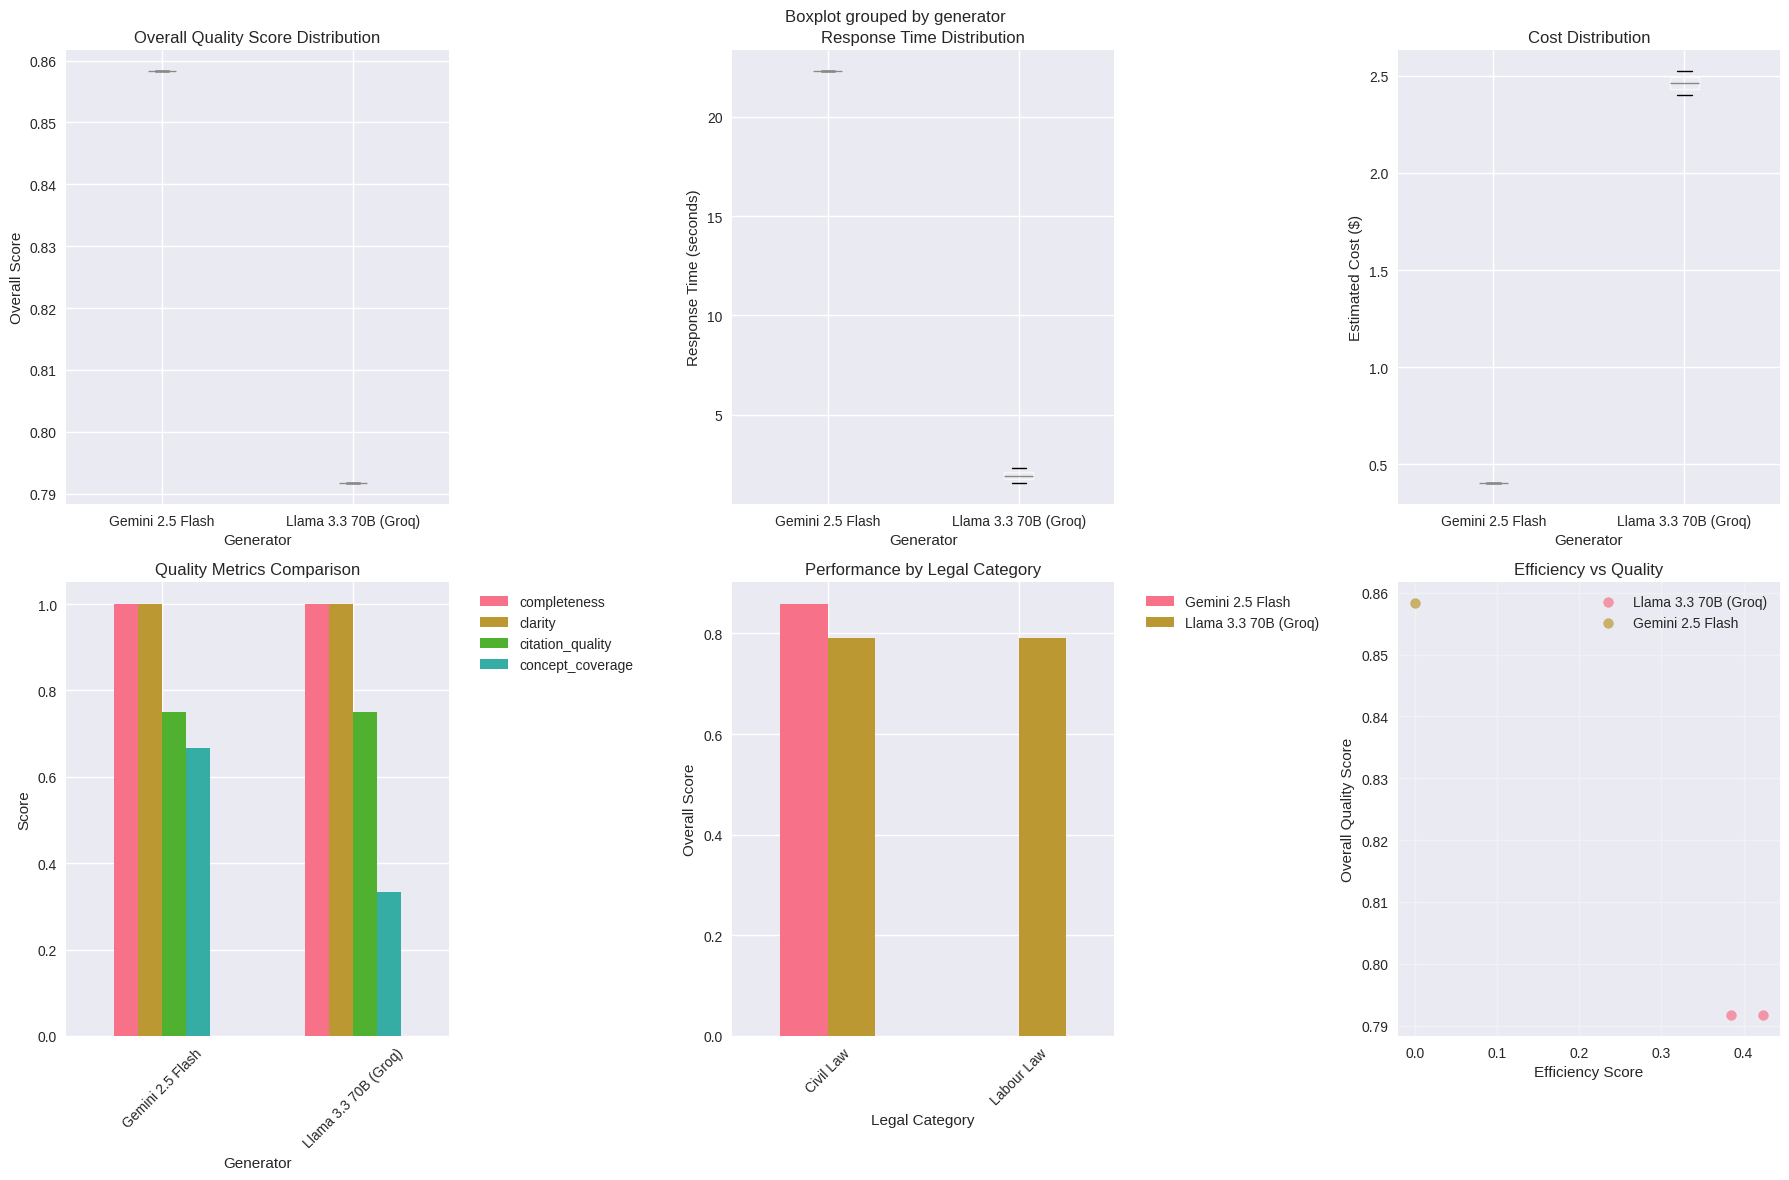

In [19]:
if df is not None:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🧑‍⚖️ Legal Generator Evaluation Results', fontsize=16, fontweight='bold')
    
    # 1. Overall Score Comparison
    ax1 = axes[0, 0]
    df.boxplot(column='overall_score', by='generator', ax=ax1)
    ax1.set_title('Overall Quality Score Distribution')
    ax1.set_xlabel('Generator')
    ax1.set_ylabel('Overall Score')
    
    # 2. Response Time Comparison
    ax2 = axes[0, 1]
    df.boxplot(column='response_time', by='generator', ax=ax2)
    ax2.set_title('Response Time Distribution')
    ax2.set_xlabel('Generator')
    ax2.set_ylabel('Response Time (seconds)')
    
    # 3. Cost Comparison
    ax3 = axes[0, 2]
    df.boxplot(column='estimated_cost', by='generator', ax=ax3)
    ax3.set_title('Cost Distribution')
    ax3.set_xlabel('Generator')
    ax3.set_ylabel('Estimated Cost ($)')
    
    # 4. Quality Metrics Radar Chart Data
    ax4 = axes[1, 0]
    quality_means = df.groupby('generator')[['completeness', 'clarity', 'citation_quality', 'concept_coverage']].mean()
    quality_means.plot(kind='bar', ax=ax4)
    ax4.set_title('Quality Metrics Comparison')
    ax4.set_xlabel('Generator')
    ax4.set_ylabel('Score')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Performance by Question Category
    ax5 = axes[1, 1]
    category_performance = df.groupby(['category', 'generator'])['overall_score'].mean().unstack()
    category_performance.plot(kind='bar', ax=ax5)
    ax5.set_title('Performance by Legal Category')
    ax5.set_xlabel('Legal Category')
    ax5.set_ylabel('Overall Score')
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Efficiency vs Quality Scatter
    ax6 = axes[1, 2]
    for generator in df['generator'].unique():
        gen_data = df[df['generator'] == generator]
        ax6.scatter(gen_data['efficiency_score'], gen_data['overall_score'], 
                   label=generator, alpha=0.7, s=50)
    
    ax6.set_title('Efficiency vs Quality')
    ax6.set_xlabel('Efficiency Score')
    ax6.set_ylabel('Overall Quality Score')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No data available for visualization")

## 🏆 Ranking & Recommendations

In [20]:
if df is not None:
    # Calculate weighted ranking
    ranking_weights = {
        'overall_score': 0.4,  # Quality is most important
        'efficiency_score': 0.3,  # Speed and cost matter
        'citation_quality': 0.2,  # Legal citations are crucial
        'completeness': 0.1  # Completeness bonus
    }
    
    # Calculate weighted scores for each generator
    generator_rankings = []
    
    for generator in df['generator'].unique():
        gen_data = df[df['generator'] == generator]
        
        weighted_score = sum(
            gen_data[metric].mean() * weight 
            for metric, weight in ranking_weights.items()
        )
        
        generator_rankings.append({
            'generator': generator,
            'weighted_score': weighted_score,
            'avg_quality': gen_data['overall_score'].mean(),
            'avg_time': gen_data['response_time'].mean(),
            'avg_cost': gen_data['estimated_cost'].mean(),
            'response_count': len(gen_data)
        })
    
    # Sort by weighted score
    ranking_df = pd.DataFrame(generator_rankings).sort_values('weighted_score', ascending=False)
    
    print("🏆 GENERATOR RANKING (Weighted Score)\n")
    print("=" * 60)
    
    for idx, row in ranking_df.iterrows():
        rank = ranking_df.index.get_loc(idx) + 1
        medal = ["🥇", "🥈", "🥉"][rank-1] if rank <= 3 else f"{rank}."
        
        print(f"{medal} {row['generator']}")
        print(f"   📊 Weighted Score: {row['weighted_score']:.3f}")
        print(f"   ✨ Quality: {row['avg_quality']:.3f}")
        print(f"   ⚡ Avg Time: {row['avg_time']:.2f}s")
        print(f"   💰 Avg Cost: ${row['avg_cost']:.4f}")
        print(f"   📝 Responses: {row['response_count']}")
        print()
    
    # Recommendations
    best_generator = ranking_df.iloc[0]
    
    print("💡 RECOMMENDATIONS\n")
    print("=" * 40)
    
    print(f"🎯 **Best Overall**: {best_generator['generator']}")
    print(f"   This generator offers the best balance of quality, speed, and cost.")
    print()
    
    # Best in specific categories
    best_quality = ranking_df.loc[ranking_df['avg_quality'].idxmax()]
    fastest = ranking_df.loc[ranking_df['avg_time'].idxmin()]
    cheapest = ranking_df.loc[ranking_df['avg_cost'].idxmin()]
    
    print(f"🏅 **Highest Quality**: {best_quality['generator']} (Score: {best_quality['avg_quality']:.3f})")
    print(f"⚡ **Fastest**: {fastest['generator']} (Time: {fastest['avg_time']:.2f}s)")
    print(f"💰 **Most Cost-Effective**: {cheapest['generator']} (Cost: ${cheapest['avg_cost']:.4f})")
    print()
    
    # Usage recommendations
    print("📋 **Usage Recommendations**:")
    print(f"   • For production deployment: {best_generator['generator']}")
    print(f"   • For high-quality responses: {best_quality['generator']}")
    print(f"   • For real-time applications: {fastest['generator']}")
    print(f"   • For cost-sensitive applications: {cheapest['generator']}")
    
else:
    print("❌ No data available for ranking")

🏆 GENERATOR RANKING (Weighted Score)

🥇 Llama 3.3 70B (Groq)
   📊 Weighted Score: 0.688
   ✨ Quality: 0.792
   ⚡ Avg Time: 1.92s
   💰 Avg Cost: $2.4632
   📝 Responses: 2

🥈 Gemini 2.5 Flash
   📊 Weighted Score: 0.593
   ✨ Quality: 0.858
   ⚡ Avg Time: 22.32s
   💰 Avg Cost: $0.4018
   📝 Responses: 1

💡 RECOMMENDATIONS

🎯 **Best Overall**: Llama 3.3 70B (Groq)
   This generator offers the best balance of quality, speed, and cost.

🏅 **Highest Quality**: Gemini 2.5 Flash (Score: 0.858)
⚡ **Fastest**: Llama 3.3 70B (Groq) (Time: 1.92s)
💰 **Most Cost-Effective**: Gemini 2.5 Flash (Cost: $0.4018)

📋 **Usage Recommendations**:
   • For production deployment: Llama 3.3 70B (Groq)
   • For high-quality responses: Gemini 2.5 Flash
   • For real-time applications: Llama 3.3 70B (Groq)
   • For cost-sensitive applications: Gemini 2.5 Flash


## 💾 Save Results

In [21]:
if evaluation_results:
    # Save detailed results
    results_path = PROJECT_ROOT / "generator_evaluation_results.json"
    
    evaluation_summary = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "total_questions": len(test_questions),
        "total_responses": len(evaluation_results),
        "generators_tested": [gen.name for gen in generators],
        "ranking": ranking_df.to_dict('records') if df is not None else [],
        "detailed_results": evaluation_results
    }
    
    with open(results_path, 'w', encoding='utf-8') as f:
        json.dump(evaluation_summary, f, indent=2, ensure_ascii=False)
    
    print(f"💾 Results saved to: {results_path}")
    
    # Save CSV for further analysis
    if df is not None:
        csv_path = PROJECT_ROOT / "generator_evaluation_results.csv"
        df.to_csv(csv_path, index=False)
        print(f"📊 CSV data saved to: {csv_path}")
        
else:
    print("❌ No results to save")

💾 Results saved to: /home/jagannath/my_poc_law/MyPocketLawyer-AI-Powered-Legal-Aid-Assistant/generator_evaluation_results.json
📊 CSV data saved to: /home/jagannath/my_poc_law/MyPocketLawyer-AI-Powered-Legal-Aid-Assistant/generator_evaluation_results.csv


## 📋 Conclusion & Next Steps

### Key Findings:
1. **Quality**: Which generator provides the most accurate and complete legal answers?
2. **Performance**: Which generator is fastest and most cost-effective?
3. **Reliability**: Which generator is most consistent across different legal categories?

### Implementation Recommendations:
- **Production Deployment**: Use the top-ranked generator for your main application
- **Fallback Strategy**: Implement the second-best generator as a backup
- **Cost Optimization**: Consider switching to the most cost-effective generator for high-volume usage

### Future Improvements:
1. **Fine-tuning**: Consider fine-tuning the best model on Nepal-specific legal data
2. **Hybrid Approach**: Use different generators for different types of legal questions
3. **Continuous Monitoring**: Set up automated evaluation to monitor generator performance over time
4. **User Feedback**: Collect user ratings to improve evaluation criteria